# Stats

TODO:
OUTSIDE NOTEBOOK
- label more points
- save masks
- save floats and not ints for label

## Setup

### Imports

In [70]:
import os
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
from amftrack.util.sys import storage_path

In [71]:
path = os.path.join(storage_path, "test_precise_1")
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [72]:
im = imageio.imread(im_path)
print(im.shape)

(224, 120)


In [73]:
with open(label_path, 'rb') as f:
    label = np.load(f)
print(label.shape)

(224,)


In [74]:
label = np. expand_dims(label, axis =1)

In [75]:
label.shape

(224, 1)

## Visualisation

In [76]:
i = random.randint(0, 224)

In [77]:
i = 68

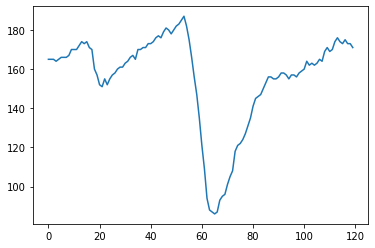

In [78]:
plt.plot(im[i,:])

In [79]:
for i in range(200):
    if label[i, 0] == 12:
        print(i)

## Data preparation

In [80]:
p = np.random.permutation(224)

In [81]:
training = p[:150]
test = p[150:]
print(len(training))
print(len(test))

150
74


In [82]:
train_feature = im[training, :]
train_label = label[training,0]
test_feature = im[test, :]
test_label = label[test, :]

In [83]:
test_feature.shape

(74, 120)

## Baseline

In [84]:
mean = np.mean(train_label)
final_score = np.mean(np.abs(test_label-mean))

In [85]:
final_score

1.306745604178807

## First model

In [118]:
from amftrack.ml.width.models import first_model
from amftrack.ml.width.data_augmentation import data_augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

In [145]:
def model1():
    input = keras.Input(shape=(120, 1))
    scaling = keras.layers.Rescaling(1.0 / 122 - 1.)(input)
    conv1 = keras.layers.Conv1D(
        filters=640, kernel_size=12, strides=3, activation="relu", name="conv1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    )(scaling)
    conv2 = keras.layers.Conv1D(
        filters=320,
        kernel_size=3,
        strides=3,
        activation="relu",
        name="conv2",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
    )(conv1)
    flatten = tf.keras.layers.Flatten()(conv2)
    dense1 = keras.layers.Dense(640, activation="relu", name="dense1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(flatten)
    dense2 = keras.layers.Dense(320, activation="relu", name="dense2")(dense1)
    output = keras.layers.Dense(1, activation=None)(dense2)
    model = keras.Model(inputs=input, outputs=output)
    return model

In [146]:
model = model1()

In [147]:
model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 120, 1)]          0         
                                                                 
 rescaling_29 (Rescaling)    (None, 120, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 37, 640)           8320      
                                                                 
 conv2 (Conv1D)              (None, 12, 320)           614720    
                                                                 
 flatten_29 (Flatten)        (None, 3840)              0         
                                                                 
 dense1 (Dense)              (None, 640)               2458240   
                                                                 
 dense2 (Dense)              (None, 320)               205

### Training

In [155]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error])

In [156]:
history = model.fit(
    train_feature,
    train_label,
    batch_size=5,
    epochs=60,
    )

Epoch 1/60
20/20 [==============================] - 1s 34ms/step - loss: 1.3086 - mean_absolute_error: 0.8090
Epoch 2/60
20/20 [==============================] - 1s 34ms/step - loss: 1.0501 - mean_absolute_error: 0.7322
Epoch 3/60
20/20 [==============================] - 1s 44ms/step - loss: 1.2617 - mean_absolute_error: 0.8200
Epoch 4/60
20/20 [==============================] - 1s 38ms/step - loss: 0.9817 - mean_absolute_error: 0.6791
Epoch 5/60
20/20 [==============================] - 1s 36ms/step - loss: 1.1220 - mean_absolute_error: 0.7631
Epoch 6/60
20/20 [==============================] - 1s 38ms/step - loss: 1.0986 - mean_absolute_error: 0.7682
Epoch 7/60
20/20 [==============================] - 1s 35ms/step - loss: 1.0349 - mean_absolute_error: 0.7350
Epoch 8/60
20/20 [==============================] - 1s 36ms/step - loss: 1.0217 - mean_absolute_error: 0.7560
Epoch 9/60
20/20 [==============================] - 1s 37ms/step - loss: 0.9533 - mean_absolute_error: 0.6967
Epoch 10/6

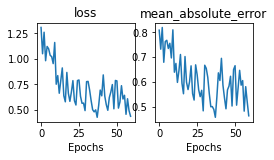

In [158]:
for i, key in enumerate(history.history.keys()):
    plt.subplot(2, 3, i+1)
    plt.plot(history.history[key])
    plt.title(key)
    plt.xlabel("Epochs")

In [157]:
model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 13ms/step - loss: 0.7931 - mean_absolute_error: 0.6656


[0.7931271195411682, 0.6656090617179871]

## Cross validation

In [150]:
from sklearn.model_selection import KFold

n_split=3
history = []

for train, valid in KFold(n_split).split(training):
    
    train_feature = im[train, :]
    train_label = label[train,0]
    valid_feature = im[valid, :]
    valid_label = label[valid, :]

    model = model1()
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error])
    
    history.append(model.fit(
    train_feature,
    train_label,
    batch_size=5,
    epochs=100,
    validation_data = (valid_feature, valid_label),
    ))

    print('Model evaluation ', model.evaluate(test_feature, test_label))

Epoch 1/100
20/20 [==============================] - 2s 49ms/step - loss: 44.1465 - mean_absolute_error: 4.5980 - val_loss: 10.2497 - val_mean_absolute_error: 2.4126
Epoch 2/100
20/20 [==============================] - 1s 35ms/step - loss: 3.6226 - mean_absolute_error: 1.2402 - val_loss: 9.5812 - val_mean_absolute_error: 2.1300
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 3.4903 - mean_absolute_error: 1.1389 - val_loss: 9.2862 - val_mean_absolute_error: 1.9401
Epoch 4/100
20/20 [==============================] - 1s 36ms/step - loss: 4.5268 - mean_absolute_error: 1.4855 - val_loss: 13.8235 - val_mean_absolute_error: 2.2914
Epoch 5/100
20/20 [==============================] - 1s 43ms/step - loss: 3.8404 - mean_absolute_error: 1.3620 - val_loss: 8.6092 - val_mean_absolute_error: 2.0924
Epoch 6/100
20/20 [==============================] - 1s 36ms/step - loss: 2.8477 - mean_absolute_error: 1.0772 - val_loss: 9.2564 - val_mean_absolute_error: 2.4647
Epoch 7/100
2

Epoch 51/100
20/20 [==============================] - 1s 36ms/step - loss: 1.0005 - mean_absolute_error: 0.6724 - val_loss: 7.5116 - val_mean_absolute_error: 1.6092
Epoch 52/100
20/20 [==============================] - 1s 39ms/step - loss: 0.9154 - mean_absolute_error: 0.6223 - val_loss: 7.5279 - val_mean_absolute_error: 2.0496
Epoch 53/100
20/20 [==============================] - 1s 38ms/step - loss: 1.0288 - mean_absolute_error: 0.6792 - val_loss: 7.0946 - val_mean_absolute_error: 1.7102
Epoch 54/100
20/20 [==============================] - 1s 40ms/step - loss: 0.8056 - mean_absolute_error: 0.5780 - val_loss: 7.1198 - val_mean_absolute_error: 1.6302
Epoch 55/100
20/20 [==============================] - 1s 41ms/step - loss: 0.8065 - mean_absolute_error: 0.5728 - val_loss: 7.1802 - val_mean_absolute_error: 1.7510
Epoch 56/100
20/20 [==============================] - 1s 39ms/step - loss: 0.8558 - mean_absolute_error: 0.5806 - val_loss: 7.3517 - val_mean_absolute_error: 1.7969
Epoch 57/1

3/3 [==============================] - 0s 15ms/step - loss: 3.0037 - mean_absolute_error: 1.1242
Model evaluation  [3.0037028789520264, 1.124208927154541]
Epoch 1/100
20/20 [==============================] - 2s 59ms/step - loss: 44.8467 - mean_absolute_error: 3.7336 - val_loss: 5.5266 - val_mean_absolute_error: 1.6351
Epoch 2/100
20/20 [==============================] - 1s 46ms/step - loss: 4.5675 - mean_absolute_error: 1.4807 - val_loss: 5.2903 - val_mean_absolute_error: 1.3165
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 3.5761 - mean_absolute_error: 1.2628 - val_loss: 4.9737 - val_mean_absolute_error: 1.3838
Epoch 4/100
20/20 [==============================] - 1s 48ms/step - loss: 3.0792 - mean_absolute_error: 1.2427 - val_loss: 8.4580 - val_mean_absolute_error: 2.0716
Epoch 5/100
20/20 [==============================] - 1s 46ms/step - loss: 3.5808 - mean_absolute_error: 1.3024 - val_loss: 5.4054 - val_mean_absolute_error: 1.7473
Epoch 6/100
20/20 [=====

Epoch 50/100
20/20 [==============================] - 1s 58ms/step - loss: 1.3989 - mean_absolute_error: 0.8074 - val_loss: 3.7162 - val_mean_absolute_error: 1.1509
Epoch 51/100
20/20 [==============================] - 1s 72ms/step - loss: 1.3365 - mean_absolute_error: 0.7744 - val_loss: 3.4954 - val_mean_absolute_error: 1.1507
Epoch 52/100
20/20 [==============================] - 1s 63ms/step - loss: 1.3074 - mean_absolute_error: 0.7324 - val_loss: 3.5674 - val_mean_absolute_error: 1.2157
Epoch 53/100
20/20 [==============================] - 1s 56ms/step - loss: 1.5154 - mean_absolute_error: 0.7688 - val_loss: 4.4505 - val_mean_absolute_error: 1.3619
Epoch 54/100
20/20 [==============================] - 2s 75ms/step - loss: 1.2500 - mean_absolute_error: 0.7347 - val_loss: 4.7814 - val_mean_absolute_error: 1.4208
Epoch 55/100
20/20 [==============================] - 1s 67ms/step - loss: 1.3833 - mean_absolute_error: 0.7862 - val_loss: 3.2965 - val_mean_absolute_error: 1.1261
Epoch 56/1

Epoch 100/100
3/3 [==============================] - 0s 10ms/step - loss: 1.8974 - mean_absolute_error: 0.8700
Model evaluation  [1.8974324464797974, 0.8700140118598938]
Epoch 1/100
20/20 [==============================] - 2s 50ms/step - loss: 35.9574 - mean_absolute_error: 4.2681 - val_loss: 3.0830 - val_mean_absolute_error: 1.3101
Epoch 2/100
20/20 [==============================] - 1s 40ms/step - loss: 7.4722 - mean_absolute_error: 1.9083 - val_loss: 5.9886 - val_mean_absolute_error: 2.0147
Epoch 3/100
20/20 [==============================] - 1s 38ms/step - loss: 9.0830 - mean_absolute_error: 2.2182 - val_loss: 2.1499 - val_mean_absolute_error: 1.0031
Epoch 4/100
20/20 [==============================] - 1s 44ms/step - loss: 5.3662 - mean_absolute_error: 1.6016 - val_loss: 1.6831 - val_mean_absolute_error: 0.8712
Epoch 5/100
20/20 [==============================] - 1s 44ms/step - loss: 4.5453 - mean_absolute_error: 1.3778 - val_loss: 5.6839 - val_mean_absolute_error: 2.0031
Epoch 6/1

Epoch 49/100
20/20 [==============================] - 1s 39ms/step - loss: 1.6636 - mean_absolute_error: 0.9066 - val_loss: 1.0271 - val_mean_absolute_error: 0.6827
Epoch 50/100
20/20 [==============================] - 1s 36ms/step - loss: 1.5457 - mean_absolute_error: 0.8314 - val_loss: 1.1522 - val_mean_absolute_error: 0.7356
Epoch 51/100
20/20 [==============================] - 1s 36ms/step - loss: 1.6302 - mean_absolute_error: 0.9084 - val_loss: 0.9921 - val_mean_absolute_error: 0.6824
Epoch 52/100
20/20 [==============================] - 1s 36ms/step - loss: 1.5465 - mean_absolute_error: 0.8346 - val_loss: 1.3505 - val_mean_absolute_error: 0.8553
Epoch 53/100
20/20 [==============================] - 1s 35ms/step - loss: 1.6550 - mean_absolute_error: 0.9008 - val_loss: 3.1943 - val_mean_absolute_error: 1.5285
Epoch 54/100
20/20 [==============================] - 1s 53ms/step - loss: 1.7678 - mean_absolute_error: 0.9699 - val_loss: 1.0623 - val_mean_absolute_error: 0.7404
Epoch 55/1

Epoch 99/100
20/20 [==============================] - 1s 41ms/step - loss: 1.2212 - mean_absolute_error: 0.7722 - val_loss: 0.9411 - val_mean_absolute_error: 0.6652
Epoch 100/100
3/3 [==============================] - 0s 18ms/step - loss: 2.2212 - mean_absolute_error: 1.1801
Model evaluation  [2.2212486267089844, 1.180052399635315]


(0.0, 20.0)

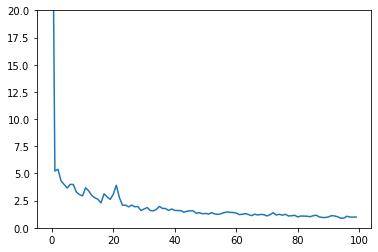

In [151]:
plt.plot(np.mean([history[i].history['loss'] for i in range(3)], axis = 0))
plt.ylim(0,20)

In [152]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

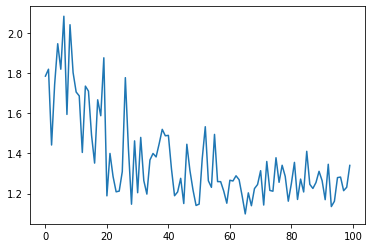

In [153]:
plt.plot(np.mean([history[i].history['val_mean_absolute_error'] for i in range(3)], axis = 0))

In [ ]:
validation =

plt.plot()

Brouillon

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = [
  {'hidden_layer_sizes': [ (50,), (100,), (20,20,20), (100, 100), (100, 100, 20), (10, 10), (30, 30, 20)], 
   'learning_rate_init':[0.001, 0.01],
   'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],
  }
 ]
print(param_grid)

# Cross-validation grid-search (for finding best possible accuracy)
clf = GridSearchCV(MLPRegressor(max_iter = 800,
                     early_stopping=True, 
                     n_iter_no_change = 10,
                     learning_rate_init = 0.0001,
                     alpha = 0.0001,
                     batch_size = 50,
                     hidden_layer_sizes=(40,40),
                     validation_fraction = 0.2,
                     random_state = 39,
                     verbose = 2), param_grid = param_grid, cv=3, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import KFold

n_split=3

for train_index, test_index in KFold(n_split).split(X):
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]

    model=create_model()
    model.fit(x_train, y_train,epochs=20)

    print('Model evaluation ',model.evaluate(x_test,y_test))

In [94]:
from sklearn.model_selection import KFold
KFold(3).split([1, 2, 3])

<generator object _BaseKFold.split at 0x7f6f829a92e0>